In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import holidays
from sklearn.cluster import KMeans
from string import ascii_letters
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import mplleaflet
pd.set_option('display.max_columns',60)

# Step 1: Define Helper Functions

In [2]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

# Step 2: Load Dataset

In [3]:
train_df = pd.read_csv('train.csv',index_col = 0)
#test_df = pd.read_csv('test.csv',index_col = 0)

C:\Users\zhang\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Step 3: EDA

## Seasonal Trend 

In [4]:
# Time Series of Trip Count
daily_trip = train_df[['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_date')
daily_trip.columns = ['Date','Daily Trip Count','Avg Trip Duration','Avg Distance']
daily_trip = daily_trip.groupby('Date').agg('mean').reset_index().set_index('Date')

### Time Series Plot of Daily Trip Counts, Average Trip Duration(s) and Average Distance (mile)

Text(0, 0.5, 'Avg Distance(mile)')

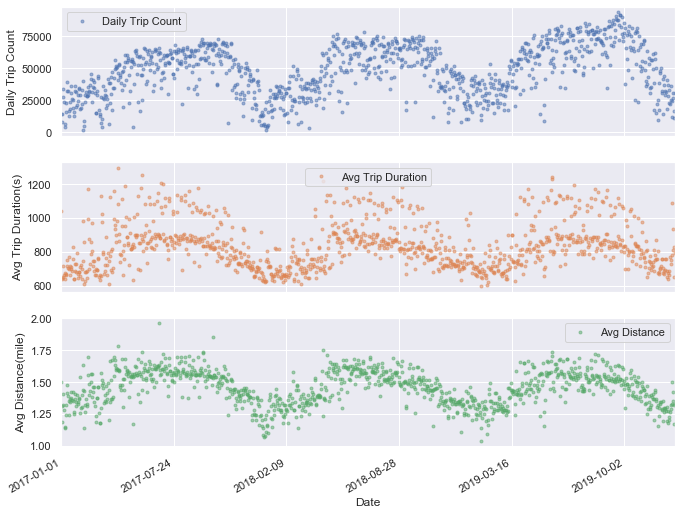

In [5]:
sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = daily_trip[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

### Monthly Aaverage Trip Counts

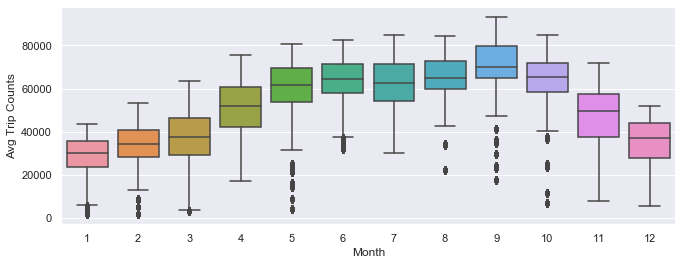

In [6]:
month_trip = train_df[['start_month','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_month')
month_trip.columns=['Month','Avg Trip Counts','Avg Trip Duration','Avg Distance'] 
sns.boxplot(x="Month", y="Avg Trip Counts", data=month_trip)

### Monthly Average Trip Duration(s)

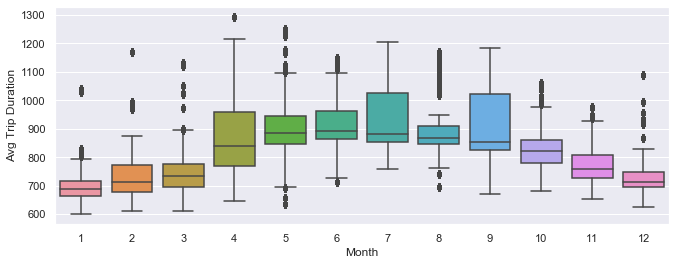

In [7]:
sns.boxplot(x="Month", y="Avg Trip Duration",  data=month_trip)

### Monthly Average Bike Distance(mile)

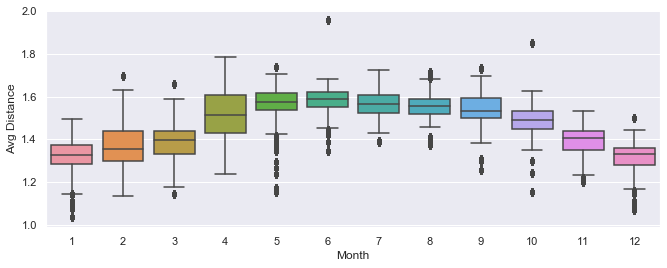

In [8]:
sns.boxplot(x="Month", y="Avg Distance", data=month_trip)

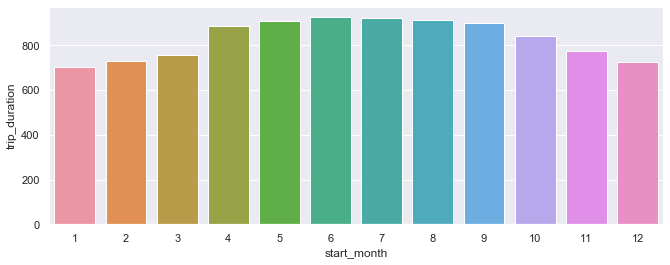

In [9]:
a = train_df.groupby('start_month').mean()[['trip_duration']].reset_index()
sns.barplot(x = a.start_month, y = a.trip_duration)

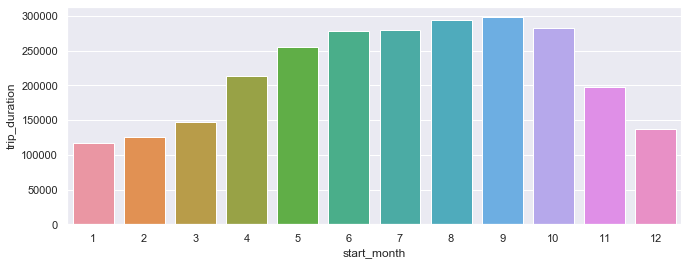

In [10]:
b = train_df.groupby('start_month').count()[['trip_duration']].reset_index()
sns.barplot(x = b.start_month, y = b.trip_duration)

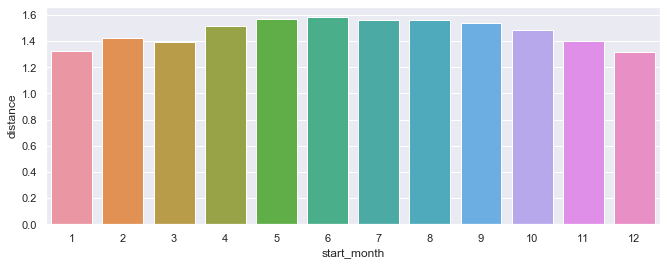

In [11]:
c = train_df.groupby('start_month').mean()[['distance']].reset_index()
sns.barplot(x = c.start_month, y = c.distance)

## Weather Impact

### Temperature's impact on ride counts

[Text(0.5, 1.0, 'Trip Count per Day v.s. Average Temperature')]

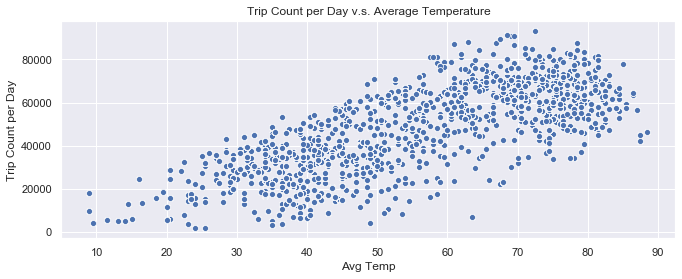

In [12]:
TEMP = train_df[['TAVG','trip_duration','trip_per_day','daily_avg_distance']]
TEMP.columns = ['Avg Temp','Avg Trip Duration(s)','Trip Count per Day','Avg Distance(mile)']
sns.scatterplot(x='Avg Temp',y='Trip Count per Day',data = TEMP).set(title = 'Trip Count per Day v.s. Average Temperature')


### Unusual Weather Conditions' impact on Ride Counts

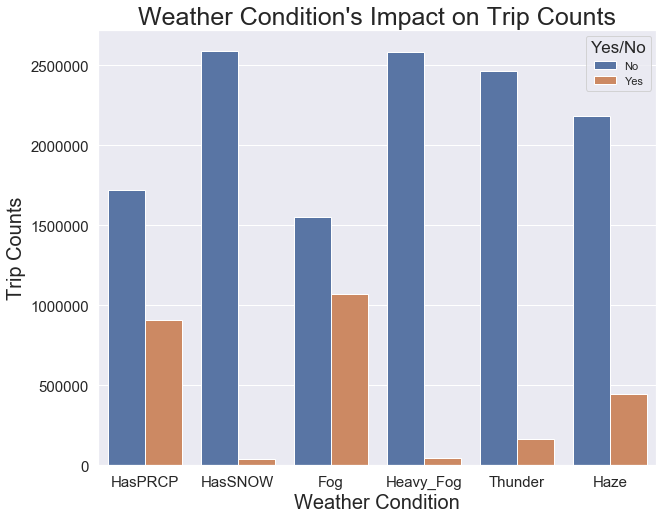

In [13]:
extreme_weather = train_df[['HasPRCP','HasSNOW','Fog', 'Heavy_Fog', 'Thunder', 'Haze']].apply(pd.value_counts)
extreme_weather= extreme_weather.unstack().reset_index()
extreme_weather.columns=['Weather Condition','Yes/No','Trip Counts']
extreme_weather['Yes/No']=['Yes' if x==1 else 'No' for x in extreme_weather['Yes/No']]
plt.figure(figsize=(10,8))
plt.rcParams["axes.labelsize"] = 20
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Weather Condition's Impact on Trip Counts", fontdict = {'fontsize' : 25})
sns.barplot(x='Weather Condition', y ='Trip Counts', hue ='Yes/No', data = extreme_weather)

## Number of stations in different years

In [14]:
train_df.loc[train_df.start_year == 2017].start_station_ID.nunique() 
train_df.loc[train_df.start_year == 2018].start_station_ID.nunique() 
train_df.loc[train_df.start_year == 2019].start_station_ID.nunique() 
train_df.start_station_ID.nunique()  
station_2017 = list(train_df.loc[train_df.start_year == 2017].start_station_ID.unique())
station_2018 = list(train_df.loc[train_df.start_year == 2018].start_station_ID.unique())
station_2019 = list(train_df.loc[train_df.start_year == 2019].start_station_ID.unique())
remove2018 =[item for item in station_2017 if item not in station_2018]
new2018 =[item for item in station_2018 if item not in station_2017]
remove2019 = [item for item in station_2018 if item not in station_2019]
new2019 =[item for item in station_2019 if item not in station_2018]
print('Number of stations removed in 2018: %.f' %len(remove2018))
print('Number of stations removed in 2019: %.f' %len(remove2019))
print('Number of stations added in 2018: %.f' %len(new2018))
print('Number of stations added in 2019: %.f' %len(new2019))

Number of stations removed in 2018: 40
Number of stations removed in 2019: 47
Number of stations added in 2018: 56
Number of stations added in 2019: 161


- 2017 has 799 unique stations, 2018 has 812 unique stations, and 2019 has 926 unique stations.
- Total unique stations for all three years are 1011 stations 

## Weekdays and Weekends

Text(0, 0.5, 'Avg Distance(mile)')

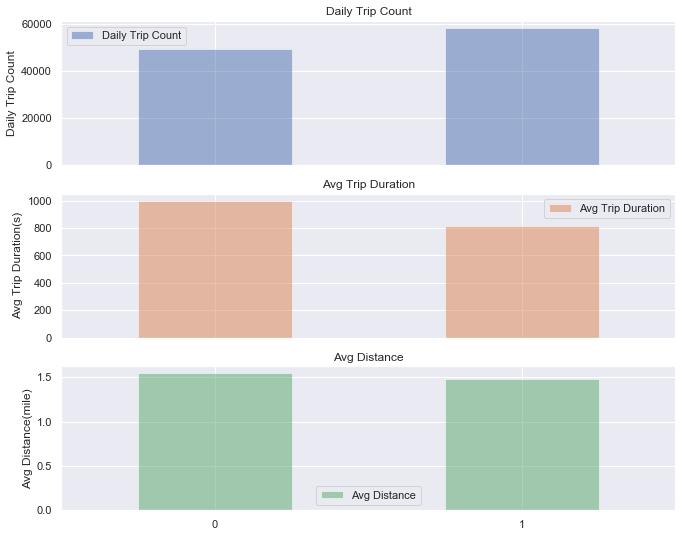

In [15]:
Weekday = train_df[['Isweekday','trip_per_day','daily_avg_trip_duration','daily_avg_distance']]
Weekday.columns =  ['Isweekday','Daily Trip Count','Avg Trip Duration','Avg Distance']
Weekday = Weekday.groupby('Isweekday').agg('mean').reset_index()

sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = Weekday[cols_plot].plot(kind='bar', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True,rot = 0)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

## Rush Hours

In [16]:
# Group by the start_hour and see the frequency correspond to each starting hour
train_df.groupby('start_hour').count()[['trip_duration']].sort_values(by = 'trip_duration', ascending = False).head(6)

,trip_duration
start_hour,
17,265637
18,252658
8,217400
16,193295
19,176047
9,172834


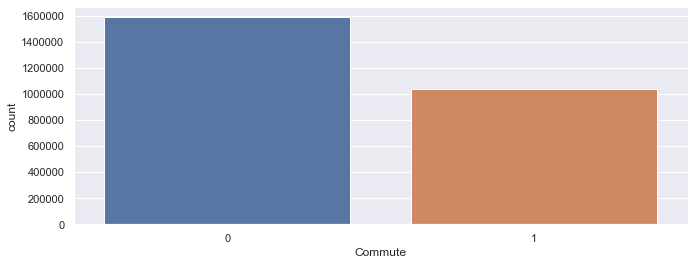

In [17]:
# Assuming bikers during peak hours on weekdays are commuting
rushhours = [8,9,16,17,18,19]
train_df['Commute'] = np.where(((train_df['Isweekday']==1) &
                                        (train_df['start_hour'].isin(rushhours))),1,0)
sns.countplot(x = 'Commute',data = train_df)

## Top 50 Stations on Weekdays and Weekend

In [18]:
top50_weekdays = train_df.loc[train_df['Isweekday']==1].groupby(['start_station_name']).\
agg({'start_station_total_counts':'mean','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'start_station_total_counts', ascending = False).head(50)

top50_weekends = train_df.loc[train_df['Isweekday']==0].groupby(['start_station_name']).\
agg({'start_station_total_counts':'mean','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'start_station_total_counts', ascending = False).head(50)

In [19]:
# Merge Dataset and export csv for Tableau Visualization
top50_weekdays['Isweekday'] ='Weekday'
top50_weekends['Isweekday'] ='Weekend'
top50_all_days = pd.concat([top50_weekdays,top50_weekends],axis = 0).reset_index()
top50_all_days.columns=['Station Name','Trip Count','Latitude','Longitude','Isweekday']
top50_all_days.to_csv('Top50_All_Days.csv')

In [20]:
top50_all_days.head()

,Station Name,Trip Count,Latitude,Longitude,Isweekday
0,Pershing Square North,121.022568,40.751873,-73.977706,Weekday
1,E 47 St & Park Ave,77.285171,40.755103,-73.974987,Weekday
2,Broadway & E 22 St,75.111562,40.740343,-73.989551,Weekday
3,8 Ave & W 31 St,68.563875,40.750585,-73.994685,Weekday
4,West St & Chambers St,66.689360,40.717548,-74.013221,Weekday


In [49]:
# plt.figure(figsize=(15,10))
# plt.plot(top50_weekdays['start_station_longitude'].values, top50_weekdays['start_station_latitude'].values, 'ro',alpha = 0.5,markersize=8)
# plt.plot(top50_weekends['start_station_longitude'].values, top50_weekends['start_station_latitude'].values, 'bv',alpha = 0.5,markersize=8)
# mplleaflet.display(tiles='cartodb_positron')

## Top 50 start stations on weekdays during rush hours

In [22]:
top50_weekdays_rush_start = train_df.loc[train_df['Commute']==1].groupby(['start_station_name']).\
agg({'start_station_checkout_counts':'mean','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'start_station_checkout_counts', ascending = False).head(50)
top50_weekdays_rush_start['Isstart'] ='Start Station'
top50_weekdays_rush_start = top50_weekdays_rush_start.reset_index()
top50_weekdays_rush_start.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [23]:
# Top 50 end stations on weekdays during rush hours
top50_weekdays_rush_end = train_df.loc[train_df['Commute']==1].groupby(['end_station_name']).\
agg({'end_station_checkout_counts':'mean','end_station_latitude':lambda x: x.iloc[0], 'end_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'end_station_checkout_counts', ascending = False).head(50)
top50_weekdays_rush_end['Isstart'] = 'End Station'
top50_weekdays_rush_end.reset_index(inplace=True)
top50_weekdays_rush_end.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [24]:
# Merge Dataset and export csv for Tableau Visualization
top50_rushhours = pd.concat([top50_weekdays_rush_start,top50_weekdays_rush_end],axis = 0)
top50_rushhours.to_csv('Top50_Rushhours.csv')

In [25]:
top50_rushhours.head()

,Station Name,Trip Count,Latitude,Longitude,Isstart
0,Pershing Square North,82.790365,40.751873,-73.977706,Start Station
1,E 47 St & Park Ave,67.031753,40.755103,-73.974987,Start Station
2,Broadway & E 22 St,64.021218,40.740343,-73.989551,Start Station
3,Penn Station Valet - Valet Scan,57.203390,40.751284,-73.996925,Start Station
4,W 52 St & 6 Ave,56.646743,40.761330,-73.979820,Start Station


In [48]:
# # Top 50 start and end stations during commuting rush hours
# plt.figure(figsize=(15,10))
# plt.plot(top50_weekdays_rush_start['Longitude'].values, 
#          top50_weekdays_rush_start['Latitude'].values, 'bv',alpha = 0.5,markersize=8)
# plt.plot(top50_weekdays_rush_end['Longitude'].values, 
#          top50_weekdays_rush_end['Latitude'].values, 'ro',alpha = 0.5,markersize=8)
# mplleaflet.display(tiles='cartodb_positron')

## Correlation Heat Map

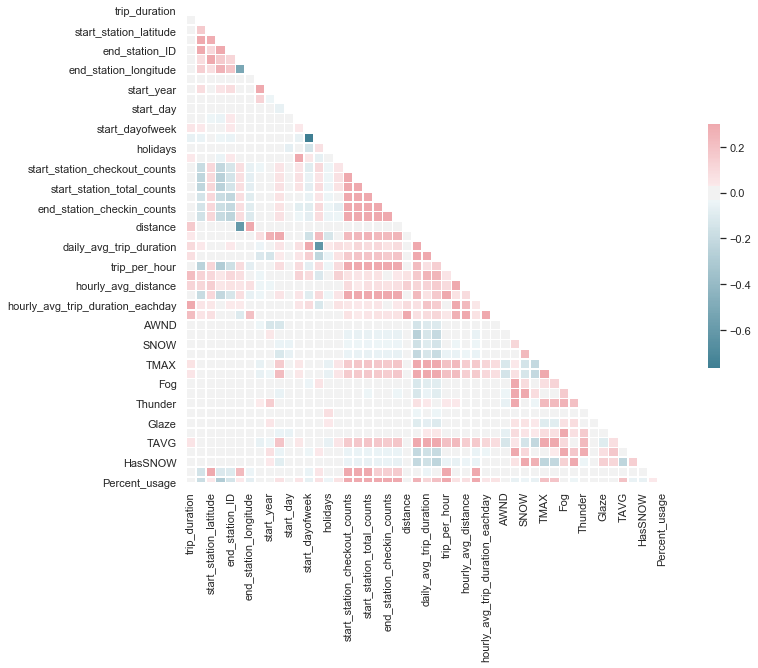

In [32]:
sns.set(style="white")
corr =train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [53]:
corr[['start_station_checkout_counts']].sort_values(by='start_station_checkout_counts',ascending=True)

,start_station_checkout_counts
start_station_longitude,-0.211397
start_station_ID,-0.188343
end_station_ID,-0.126689
start_dayofweek,-0.087265
end_station_longitude,-0.061161
PRCP,-0.051073
SNWD,-0.049404
HasSNOW,-0.048350
HasPRCP,-0.043116
holidays,-0.035709


In [33]:
# corr.to_csv('Correlation_Matrix.csv')

## K-mean Clustering 
- Create clusters on dock stations based on location and usage, what else could be useful? 

In [34]:
train_df.columns

Index(['trip_duration', 'starttime', 'stoptime', 'start_station_ID',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_ID', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_ID',
       'start_date', 'start_year', 'start_month', 'start_day', 'start_hour',
       'start_dayofweek', 'Isweekday', 'holidays', 'stop_date', 'stop_hour',
       'start_station_checkout_counts', 'start_station_checkin_counts',
       'start_station_total_counts', 'end_station_checkout_counts',
       'end_station_checkin_counts', 'end_station_total_counts', 'distance',
       'trip_per_day', 'daily_avg_trip_duration', 'daily_avg_distance',
       'trip_per_hour', 'hourly_avg_trip_duration', 'hourly_avg_distance',
       'trip_per_hour_eachday', 'hourly_avg_trip_duration_eachday',
       'hourly_avg_distance_eachday', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'Fog', 'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze', 'T

In [77]:
station = train_df.groupby(['start_station_name']).agg({'start_station_total_counts':'mean','Percent_usage':'mean',
                                                         'distance': 'mean'})

station.reset_index(inplace=True)

In [78]:
station = station.dropna(how = 'any')
station= station.loc[station.Percent_usage<5]
station.shape

(957, 4)

In [79]:
station.sample(10)

,start_station_name,start_station_total_counts,Percent_usage,distance
833,Sterling Pl & Bedford Ave,4.889908,0.195596,1.818208
154,Allen St & Hester St,21.650083,0.503490,1.411461
220,Broadway & W 55 St,20.537736,0.348097,1.260937
193,Bond St & Fulton St,12.773407,0.412045,1.243519
159,Amsterdam Ave & W 66 St,9.188235,0.437535,1.701316
781,Riverside Blvd & W 67 St,17.710372,0.454065,2.257072
635,Lewis Ave & Decatur St,3.075000,0.161842,1.960304
623,Laight St & Hudson St,8.333139,0.362310,1.643680
372,E 118 St & Park Ave,3.019169,0.111821,1.277539
535,Graham Ave & Grand St,6.185115,0.268678,1.504355


In [80]:
scaler = StandardScaler()
scaler.fit(station.iloc[:,1:])
station_scaled = scaler.transform(station.iloc[:,1:])
kmeans = KMeans()

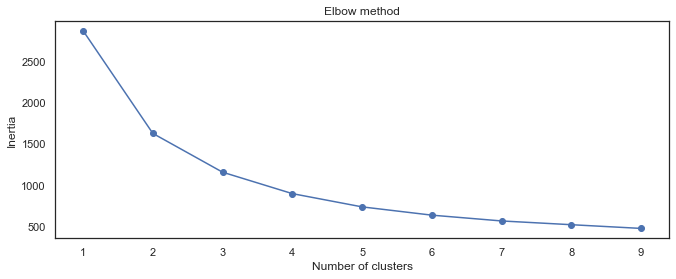

In [81]:
plot_inertia(kmeans, station_scaled, range(1, 10))

In [82]:
kmeans.set_params(n_clusters=4)
kmeans.fit(station_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [83]:
kmeans.cluster_centers_

array([[ 0.82087841,  0.80768621, -0.35596986],
       [-0.52741519, -0.58848926,  1.65709589],
       [-0.54277787, -0.50886167, -0.34276612],
       [ 2.57578606,  2.49780165,  0.14462256]])

In [84]:
#pd.concat([station,station_labels],axis=1)
station['cluster']= kmeans.labels_
station

,start_station_name,start_station_total_counts,Percent_usage,distance,cluster
0,1 Ave & E 110 St,6.260638,0.250426,1.565800,2
1,1 Ave & E 16 St,30.574408,0.678971,1.233613,0
2,1 Ave & E 18 St,23.536457,0.602141,1.262080,0
3,1 Ave & E 30 St,20.874468,0.719809,1.466789,0
4,1 Ave & E 44 St,21.718126,0.555438,1.714431,0
...,...,...,...,...,...
1004,Wyckoff St & 3 Ave,5.396618,0.245301,1.251272,2
1006,Wythe Ave & Metropolitan Ave,17.702107,0.655634,1.467607,0
1007,Yankee Ferry Terminal,37.950142,0.903575,2.394823,3
1008,York St & Jay St,17.662847,0.654180,1.575283,0


In [85]:
station_geo = train_df.groupby('start_station_name')[['start_station_longitude','start_station_latitude']].apply(lambda x:x.iloc[0])
station_geo.reset_index(inplace=True)

In [86]:
cluster = station.merge(station_geo,how='left',on='start_station_name')
cluster

,start_station_name,start_station_total_counts,Percent_usage,distance,cluster,start_station_longitude,start_station_latitude
0,1 Ave & E 110 St,6.260638,0.250426,1.565800,2,-73.938300,40.792327
1,1 Ave & E 16 St,30.574408,0.678971,1.233613,0,-73.981656,40.732219
2,1 Ave & E 18 St,23.536457,0.602141,1.262080,0,-73.980544,40.733812
3,1 Ave & E 30 St,20.874468,0.719809,1.466789,0,-73.975361,40.741444
4,1 Ave & E 44 St,21.718126,0.555438,1.714431,0,-73.969053,40.750020
...,...,...,...,...,...,...,...
952,Wyckoff St & 3 Ave,5.396618,0.245301,1.251272,2,-73.982586,40.682755
953,Wythe Ave & Metropolitan Ave,17.702107,0.655634,1.467607,0,-73.963198,40.716887
954,Yankee Ferry Terminal,37.950142,0.903575,2.394823,3,-74.016966,40.686931
955,York St & Jay St,17.662847,0.654180,1.575283,0,-73.986569,40.701485


In [87]:
cluster.to_csv('cluster.csv')

In [89]:
cluster.groupby('cluster').agg({'start_station_total_counts':'mean','Percent_usage':'mean','distance':'mean'})

,start_station_total_counts,Percent_usage,distance
cluster,,,
0,22.556680,0.627420,1.424402
1,6.555366,0.203562,2.227801
2,6.373045,0.227736,1.429671
3,43.383619,1.140513,1.624184


In [69]:
cluster_reduced = cluster[['start_station_name','cluster']]
train_df = train_df.merge(cluster_reduced, how='left',on='start_station_name')

In [60]:
train_df.merge(cluster_reduced, how='left',on='start_station_name').dropna()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,Percent_usage,Commute,cluster
0,538,2017-01-19 18:46:58,2017-01-19 18:55:56,519.0,Pershing Square North,40.751873,-73.977706,515.0,W 43 St & 10 Ave,40.760094,-73.994618,16671,2017-01-19,2017,1,19,18,4,1,0,2017-01-19,18,92.0,72.0,164.0,4.0,12.0,16.0,1.463633,35672,708.974658,1.420254,1147.0,764.414124,1.556025,92.0,740.130435,1.490564,3.58,0.00,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0,2.688525,1,1.0
1,538,2017-01-21 11:13:23,2017-01-21 11:22:22,116.0,W 17 St & 8 Ave,40.741776,-74.001497,503.0,E 20 St & Park Ave,40.738274,-73.987520,25795,2017-01-21,2017,1,21,11,6,0,0,2017-01-21,11,7.0,16.0,23.0,5.0,9.0,14.0,0.982443,25216,829.179806,1.420891,80.0,649.837500,1.176237,7.0,932.285714,1.553252,3.80,0.00,0.0,0.0,49,41,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0,0,39.0,0.589744,0,2.0
2,996,2017-01-04 08:35:33,2017-01-04 08:52:09,301.0,E 2 St & Avenue B,40.722174,-73.983688,146.0,Hudson St & Reade St,40.716250,-74.009106,17358,2017-01-04,2017,1,4,8,3,1,0,2017-01-04,8,17.0,3.0,20.0,6.0,5.0,11.0,1.755941,33455,714.582663,1.407101,385.0,829.384416,1.601648,17.0,857.823529,1.569631,8.05,0.00,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,37.0,0.540541,1,2.0
3,1656,2017-01-13 20:13:23,2017-01-13 20:40:59,483.0,E 12 St & 3 Ave,40.732233,-73.988900,3246.0,Montague St & Clinton St,40.694281,-73.992300,26555,2017-01-13,2017,1,13,20,5,1,0,2017-01-13,20,6.0,4.0,10.0,1.0,2.0,3.0,2.798899,32550,705.899816,1.388478,160.0,580.875000,1.061558,6.0,649.833333,1.235200,7.16,0.00,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,35.0,0.285714,0,2.0
4,203,2017-01-25 18:18:56,2017-01-25 18:22:20,525.0,W 34 St & 11 Ave,40.755942,-74.002116,458.0,11 Ave & W 27 St,40.751396,-74.005226,16993,2017-01-25,2017,1,25,18,3,1,0,2017-01-25,18,8.0,3.0,11.0,6.0,6.0,12.0,0.478460,36154,726.042015,1.407985,102.0,649.205882,1.358876,8.0,655.500000,1.074977,6.71,0.00,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,39.0,0.282051,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625197,236,2019-12-03 06:52:26.733,2019-12-03 06:56:23.013,389.0,Broadway & Berry St,40.710446,-73.965251,3093.0,N 6 St & Bedford Ave,40.717452,-73.958509,26076,2019-12-03,2019,12,3,6,2,1,0,2019-12-03,6,4.0,2.0,6.0,1.0,8.0,9.0,0.840710,38464,681.709599,1.297637,56.0,343.892857,0.938282,4.0,349.750000,1.130877,7.16,0.02,0.3,1.2,36,30,1.0,0.0,0.0,0.0,0.0,0.0,33.0,1,1,27.0,0.222222,0,0.0
2625198,429,2019-12-10 17:52:05.559,2019-12-10 17:59:15.307,3301.0,Columbus Ave & W 95 St,40.791956,-73.968087,3366.0,West End Ave & W 107 St,40.802117,-73.968181,21083,2019-12-10,2019,12,10,17,2,1,0,2019-12-10,17,3.0,6.0,9.0,2.0,5.0,7.0,0.706114,41502,704.506915,1.349688,131.0,589.106870,1.207112,3.0,625.666667,1.496950,6.93,0.13,0.0,0.0,58,39,1.0,0.0,0.0,0.0,0.0,0.0,48.5,1,0,39.0,0.230769,1,0.0
2625199,599,2019-12-15 13:27:52.789,2019-12-15 13:37:52.084,3112.0,Milton St & Franklin St,40.729060,-73.957790,3085.0,Roebling St & N 4 St,40.714690,-73.957390,40551,2019-12-15,2019,12,15,13,7,0,0,2019-12-15,13,4.0,3.0,7.0,6.0,5.0,11.0,1.012730,31582,754.272054,1.270878,69.0,679.05

## Top 200 Dock Stations at All Times 

In [70]:
Top200_ID = list(train_df.groupby(['start_station_ID']).agg({'trip_duration':'count'}).\
sort_values(by='trip_duration',ascending=False).head(200).index)

In [71]:
Top200 = train_df.loc[train_df['start_station_ID'].isin(Top200_ID)]

In [72]:
Top200.columns

Index(['trip_duration', 'starttime', 'stoptime', 'start_station_ID',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_ID', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_ID',
       'start_date', 'start_year', 'start_month', 'start_day', 'start_hour',
       'start_dayofweek', 'Isweekday', 'holidays', 'stop_date', 'stop_hour',
       'start_station_checkout_counts', 'start_station_checkin_counts',
       'start_station_total_counts', 'end_station_checkout_counts',
       'end_station_checkin_counts', 'end_station_total_counts', 'distance',
       'trip_per_day', 'daily_avg_trip_duration', 'daily_avg_distance',
       'trip_per_hour', 'hourly_avg_trip_duration', 'hourly_avg_distance',
       'trip_per_hour_eachday', 'hourly_avg_trip_duration_eachday',
       'hourly_avg_distance_eachday', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'Fog', 'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze', 'T

In [73]:
selected_cols=['start_station_latitude','start_station_longitude', 'start_hour',\
              'start_year','start_month','start_day','start_dayofweek','start_station_checkout_counts',\
              'start_station_checkin_counts','AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX','TMIN', 'Fog',\
               'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze','TAVG','HasPRCP', 'HasSNOW',\
               'tot_docks', 'Percent_usage','Isweekday','holidays', 'Commute','cluster'] 
Top200 = Top200.loc[:,selected_cols]

In [75]:
Top200.drop_duplicates(inplace=True)

In [93]:
Top200.to_csv('Top200_Stations.csv')